In [1]:
%matplotlib inline
from grale.all_nb import *
import glob
import os
import pickle
import pprint

cosm = cosmology.Cosmology(0.71, 0.27, 0, 0.73)
cosmology.setDefaultCosmology(cosm)
D = cosm.getAngularDiameterDistance

z_lens = 0.68

z_Q = 1.734
z_A = 3.332
z_B = 2.74

invCenter = V(0, 5)*ANGLE_ARCSEC
slPlotWidth = 50*ANGLE_ARCSEC

critDens = lenses.getCriticalDensity(D(z_lens),D(z_Q),D(z_lens,z_Q))

iws = inversion.InversionWorkSpace(z_lens, slPlotWidth, invCenter)
imgQ = images.ImagesData.load("inversion_grale2/source1points.imgdata")
quasarPos = np.array([imgQ.getImagePointPosition(*imgQ.getGroupPointIndices(0, i)) for i in range(5) ])
quasarPosNames = [ "Q2", "Q1", "Q5", "Q4", "Q3"]
quasarNameIdx = { quasarPosNames[i]:i for i in range(len(quasarPosNames)) }

imgQPt = images.ImagesData(5)
for i in range(5):
    imgQPt.addPoint(i, quasarPos[i,:])

imgA = images.ImagesData.load("inversion_grale2/source2detailedpoints.imgdata")
imgB = images.ImagesData.load("inversion_grale2/source3detailedpoints.imgdata")
iws.addImageDataToList(imgQ, z_Q, "extendedimages", { "userectangles": False })
iws.addImageDataToList(imgA, z_A, "extendedimages")
iws.addImageDataToList(imgB, z_B, "extendedimages")

Set 'threads' as default renderer for lensplane and mass density
Set default angular unit in plotting to arcsec
Set feedback style to 'notebook'


In [2]:
liCache = { }

In [3]:
def getCacheFileName(hsh):
    return "licache_" + hsh + ".pickle"

def getLIEntry(fileNameOrLens):
    import hashlib
    
    if type(fileNameOrLens) == str:
        data = open(fileNameOrLens, "rb").read()
    else:
        data = fileNameOrLens.toBytes()
        
    s = hashlib.sha256()
    s.update(data)
    h = s.hexdigest()
    if h in liCache:
        return liCache[h]

    cfn = getCacheFileName(h)
    #print(cfn)
    if os.path.exists(cfn):
        liCache[h] = pickle.load(open(cfn, "rb"))
        assert(h == liCache[h]["hash"])
        return liCache[h]

    if type(fileNameOrLens) == str:
        lens = lenses.GravitationalLens.load(fileNameOrLens)
        fileName = fileNameOrLens
    else:
        lens = fileNameOrLens
        fileName = "(lens model)"
        
    liNarrow = plotutil.LensInfo(lens, size=slPlotWidth, center=invCenter, zd=z_lens, cosmology=cosm) 
    d = { "narrow": liNarrow, "filename": fileName, "hash": h, "lens": lens}
    liCache[h] = d
    return d
            
def saveCaches():
    for n in liCache:
        print(n, liCache[n]["filename"])
        cfn = getCacheFileName(n)
        pickle.dump(liCache[n], open(cfn,"wb"))

In [4]:
def plotContours(li):
    rgb = plt.imread("./background50x50.jpg")
    plt.imshow(rgb, extent=[25,-25,-25,25])
    plotutil.plotDensityContours(li, densityUnit=critDens,
                                 levels=np.arange(0,4,0.2))
    plotutil.plotDensityContours(li, densityUnit=critDens,
                                 levels=[1], linewidths=[2])
    plt.gca().invert_xaxis()

In [5]:
def plotLines(li):
    li.setSourceRedshift(z_Q)
    plotutil.plotImagePlane(li)
    plotutil.plotImagesData([imgQ])
    plt.gca().invert_xaxis()

In [6]:
def calculateTimeDelaysMeanStd(li):

    lens = li.getLens()
    subLenses = [p["lens"] for p in lens.getLensParameters()]
    
    refImg = quasarNameIdx["Q3"]
    
    def calcDelays(sl, thetas, beta):
        
        delays = sl.getTimeDelay(z_lens, D(z_Q), D(z_lens,z_Q), thetas, beta)
        delays -= delays[refImg]
        delays /= 60*60*24
        return delays
    
    allDelays = []
    for sl in subLenses:
        pred = util.calculateImagePredictions([ { "imgdata": imgQPt, "z": z_Q}], sl, cosm)
        beta = pred[0][0]["beta_est"][0]
        thetaPred = np.array([ x["theta_pred"][0] for x in pred[0]])
    
        #print("Using predicted image positions and estimated source position")
        d = calcDelays(sl, thetaPred, beta)
        allDelays.append(d)
    
    allDelays = np.array(allDelays).T
    avgDelays = np.mean(allDelays, axis=1)
    stdDelays = np.std(allDelays, axis=1)
    
    for i in range(len(avgDelays)):
            print(f"{quasarPosNames[refImg]} -> {quasarPosNames[i]} : {avgDelays[i]:.2f} +/- {stdDelays[i]:.2f} days")

In [7]:
def plotRelensedImages(li):
    
    lens = li.getLens()
    
    predQ = util.calculateImagePredictions([ { "imgdata": imgQPt, "z": z_Q}], lens, cosm)
    betaQ = predQ[0][0]["beta_est"][0]
    
    srcQ = images.CircularSource(betaQ, 0.1*ANGLE_ARCSEC)
    
    bpImg = iws.backProject(lens)
    bpSrc = [ images.createSourceFromImagesData(i) for i in bpImg ]
    redshifts = [ i["z"] for i in iws.getImageDataList() ]
    
    # replace the quasar by a circular source
    bpSrc[0] = srcQ
    
    srcs = [ { "shape": s, "z": z} for s, z in zip(bpSrc, redshifts) ]
    plotutil.plotImagePlane(li, srcs, plotCaustics=False, plotCriticalLines=[True,False,False], plotSources=False)
    plt.gca().invert_xaxis()

In [8]:
def getMaxDensCoord(li):
    densPoints = li.getDensityPoints()
    maxPos = densPoints.argmax()
    y = maxPos//densPoints.shape[1]
    x = maxPos%densPoints.shape[1]

    xfrac = x/(densPoints.shape[1]-1)
    yfrac = y/(densPoints.shape[0]-1)

    tr, bl = li.getArea()["topright"], li.getArea()["bottomleft"]
    
    return np.array([xfrac*(tr[0]-bl[0]) + bl[0],
                     yfrac*(tr[1]-bl[1]) + bl[1] ])

def plotAverageDensityProfileSingle(li, **kwargs):
    ctr = getMaxDensCoord(li)
    print("Density peak at: ", ctr/ANGLE_ARCSEC, "arcsec")
    plotutil.plotAverageDensityProfile(li, 15*ANGLE_ARCSEC, center=ctr, densityUnit=critDens, **kwargs);

def plotAverageDensityProfileComparison(li):
   
    plotAverageDensityProfileSingle(li)
    plotAverageDensityProfileSingle(getLIEntry("model2/model.lensdata")["narrow"], label="2009 model");
    plt.gca().set_ylim(bottom=0)
    plt.legend()

In [9]:
def plot(fn):
    plt.figure(figsize=(15,10))

    d = getLIEntry(fn)
    li = d["narrow"]
    lens = d["lens"]
    
    if plotutil._isAverageLens(lens):
        n = len(lens.getLensParameters())
        print(f"Lens appears to be an average of {n} sublenses")

    plt.subplot(2,3,1)
    plotContours(li)
        
    plt.subplot(2,3,2)
    plotAverageDensityProfileComparison(li)
    
    #plt.subplot(2,3,3)
    #plotLines(li)
    
    plt.subplot(2,3,4)
    plotutil.plotImagesData(iws.backProject(lens))
    plt.gca().invert_xaxis()
    
    plt.subplot(2,3,5)
    plotRelensedImages(li)
    
    plt.subplot(2,3,6)
    plotutil.plotDensitiesAtImagePositions(lens, [imgQ, imgA, imgB], densityUnit=critDens, reduceMethod="merge", color="blue", capsize=5, lw=5);
    plotutil.plotDensitiesAtImagePositions(getLIEntry("model2/model.lensdata")["lens"], [imgQ, imgA, imgB], densityUnit=critDens, reduceMethod="merge", color="red", label="2009 model", capsize=5)
    plt.gca().invert_xaxis()
    plt.gca().set_ylim(bottom=0)
    plt.legend()

    calculateTimeDelaysMeanStd(li)
    plt.show()
    
    plotutil.plotDensityInteractive(li, flipX=True, densityUnit=critDens)

Lens appears to be an average of 28 sublenses
Density peak at:  [-0.2446184  -0.62622309] arcsec
Density peak at:  [-0.2446184  -0.62622309] arcsec


Text(value='')

Text(value='')

Text(value='')

Text(value='')

Q3 -> Q2 : 774.28 +/- 21.40 days
Q3 -> Q1 : 814.70 +/- 21.62 days
Q3 -> Q5 : 2693.15 +/- 203.30 days
Q3 -> Q4 : 2133.96 +/- 164.10 days
Q3 -> Q3 : 0.00 +/- 0.00 days


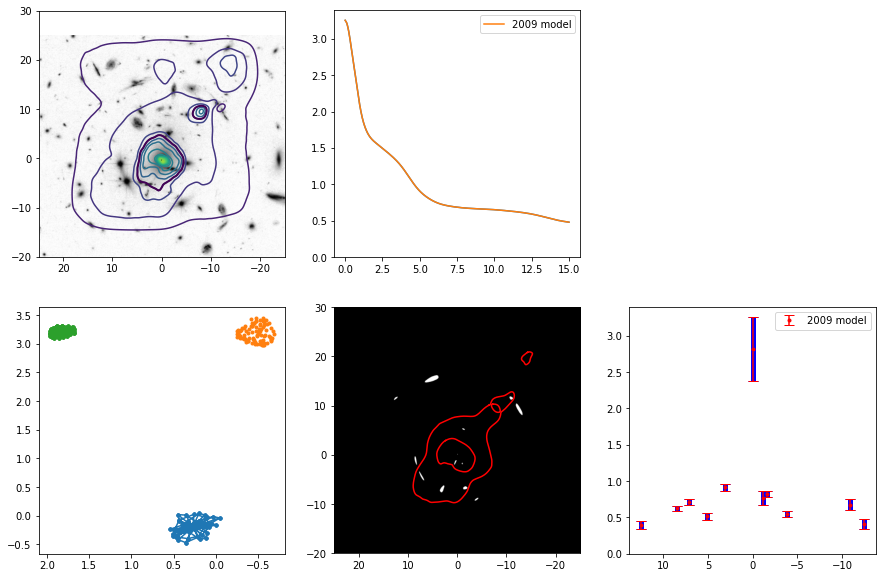

In [10]:
plot("./model2/model.lensdata")

Lens appears to be an average of 30 sublenses
Density peak at:  [ 0.14677104 -0.43052838] arcsec
Density peak at:  [-0.2446184  -0.62622309] arcsec


Text(value='')

Text(value='')

Text(value='')

Text(value='')

Q3 -> Q2 : 780.83 +/- 5.81 days
Q3 -> Q1 : 821.15 +/- 5.97 days
Q3 -> Q5 : 2955.41 +/- 226.21 days
Q3 -> Q4 : 2494.73 +/- 237.85 days
Q3 -> Q3 : 0.00 +/- 0.00 days


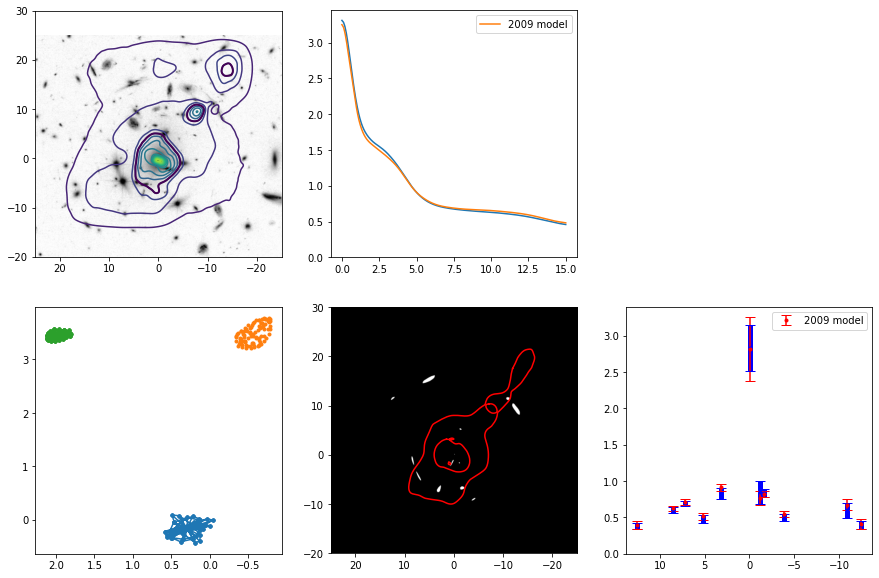

In [11]:
plot("./avg-sub_5-td_2009-pressure_2.0.lensdata")

Lens appears to be an average of 30 sublenses
Density peak at:  [-0.53816047 -0.52837573] arcsec
Density peak at:  [-0.2446184  -0.62622309] arcsec


Text(value='')

Text(value='')

Text(value='')

Text(value='')

Q3 -> Q2 : 781.21 +/- 3.58 days
Q3 -> Q1 : 821.35 +/- 3.79 days
Q3 -> Q5 : 2934.34 +/- 199.17 days
Q3 -> Q4 : 2393.05 +/- 185.25 days
Q3 -> Q3 : 0.00 +/- 0.00 days


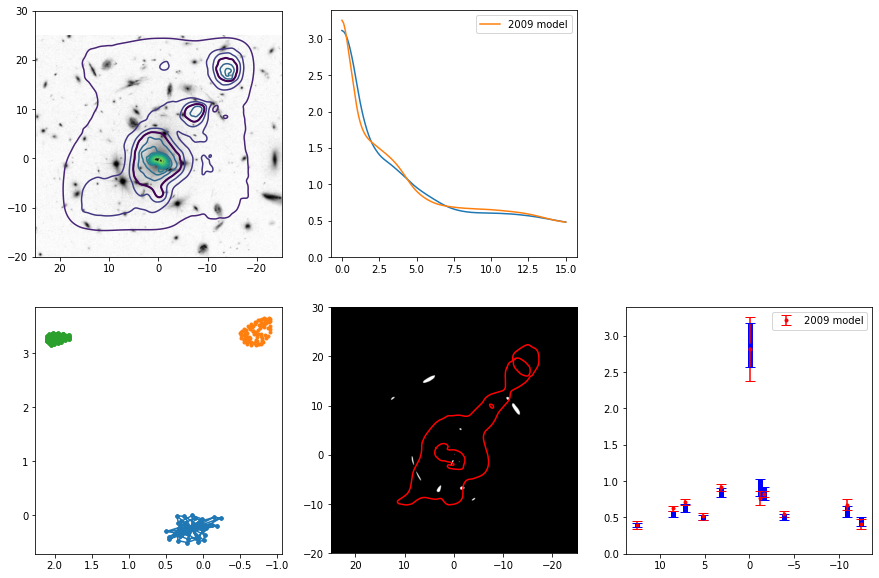

In [12]:
plot("./avg-sub_7-td_new-pressure_2.5.lensdata")

In [13]:
# This makes 'imgplane' files that can be used to backproject images and re-trace them
# using the grale_editor. See also the grale_editor subdirectory.

import pickle
li = getLIEntry("avg-sub_7-td_new-pressure_2.5.lensdata")["narrow"]
li.setSourceRedshift(z_Q)
ip = li.getImagePlane()
pickle.dump(ip, open("avg_Q.imgplane", "wb"))
li.setSourceRedshift(z_A)
ip = li.getImagePlane()
pickle.dump(ip, open("avg_A.imgplane", "wb"))
li.setSourceRedshift(z_B)
ip = li.getImagePlane()
pickle.dump(ip, open("avg_B.imgplane", "wb"))

Text(value='')

Text(value='')

Text(value='')

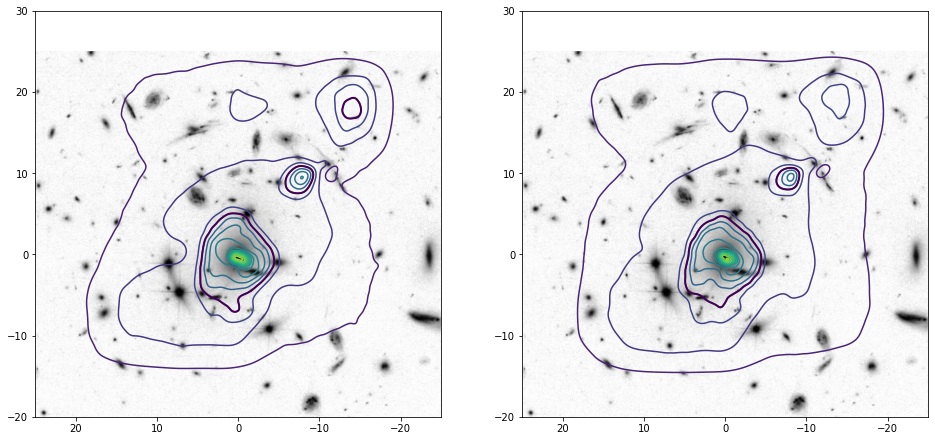

In [14]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plotContours(getLIEntry("avg-sub_5-td_2009-pressure_2.0.lensdata")["narrow"])
plt.subplot(1,2,2)
plotContours(getLIEntry("model2/model.lensdata")["narrow"])

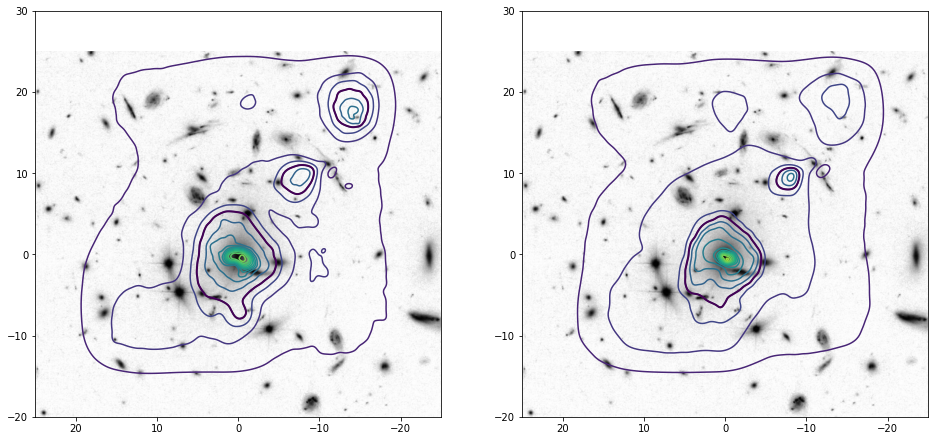

In [15]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plotContours(getLIEntry("avg-sub_7-td_new-pressure_2.5.lensdata")["narrow"])
plt.subplot(1,2,2)
plotContours(getLIEntry("model2/model.lensdata")["narrow"])

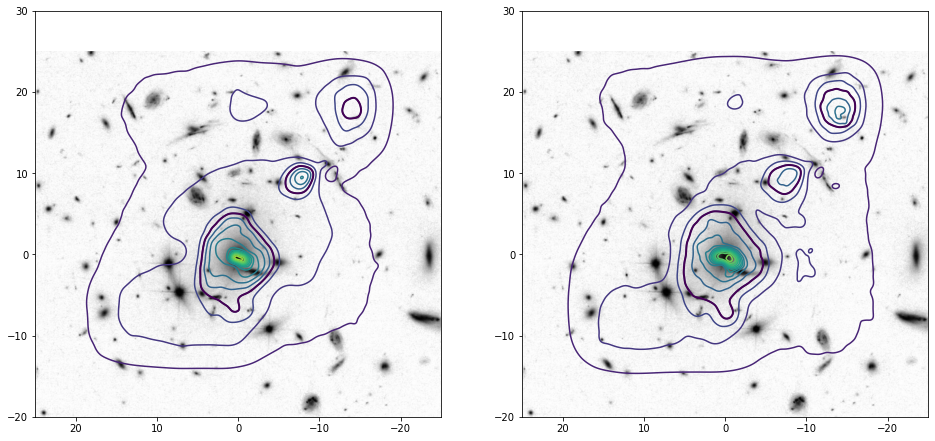

In [16]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plotContours(getLIEntry("avg-sub_5-td_2009-pressure_2.0.lensdata")["narrow"])
plt.subplot(1,2,2)
plotContours(getLIEntry("avg-sub_7-td_new-pressure_2.5.lensdata")["narrow"])

In [17]:
#saveCaches()

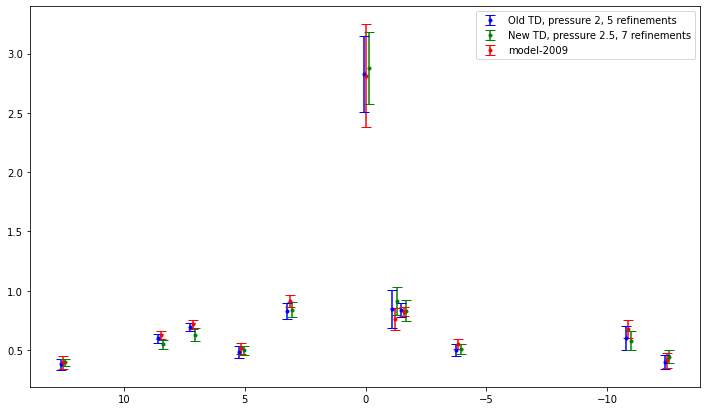

In [18]:
plt.figure(figsize=(12,7))
plotutil.plotDensitiesAtImagePositions(getLIEntry("avg-sub_5-td_2009-pressure_2.0.lensdata")["lens"], [imgQ, imgA, imgB], densityUnit=critDens, reduceMethod="merge", color="blue", label="Old TD, pressure 2, 5 refinements", capsize=5, horCoordFunction = lambda xy: xy[0]+0.1*ANGLE_ARCSEC);
plotutil.plotDensitiesAtImagePositions(getLIEntry("avg-sub_7-td_new-pressure_2.5.lensdata")["lens"], [imgQ, imgA, imgB], densityUnit=critDens, reduceMethod="merge", color="green", label="New TD, pressure 2.5, 7 refinements", capsize=5, horCoordFunction = lambda xy: xy[0]-0.1*ANGLE_ARCSEC);
plotutil.plotDensitiesAtImagePositions(getLIEntry("model2/model.lensdata")["lens"], [imgQ, imgA, imgB], densityUnit=critDens, reduceMethod="merge", color="red", label="model-2009", capsize=5, horCoordFunction = lambda xy: xy[0]);
plt.legend()
plt.gca().invert_xaxis()